In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/shwetank/code/wiki-base')
import torch
# from datasets import load_dataset
# import tiktoken

# Setup device
device = torch.device("cuda")
device

device(type='cuda')

In [2]:
# Hyperparams
batch_size = 32
block_size = 256
emb_dim = 768
num_heads = 12
num_layers = 12
dropout = 0.2
linear_scaleup = 4
temperature = 1

# Optimization loop parameters
n_epochs = 100
eval_interval =10

In [3]:
with open('./data/shakespeare/input.txt', 'r', encoding='utf-8') as file:
    text_data = file.read()

n1 = int(0.9*len(text_data))
train_data = text_data[:n1]
val_data = text_data[n1:]
vocab = sorted(set(list(text_data)))
n_vocab = len(vocab)
print(f"vocab: {vocab}")
print(f"vocab length: {n_vocab}")

vocab: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocab length: 65


In [4]:
from torch.utils.data import Dataset
import torch

class CharacterDataset(Dataset):
    def __init__(self, dataset: Dataset, block_size: int=128):
        self.block_size = block_size
        self.dataset = dataset
        
    def __len__(self) -> int:
        return self.block_size

    def __getitem__(self, idx: int) -> tuple[torch.tensor, torch.tensor]:
        # x = torch.zeros((self.block_size + 1), dtype=torch.long)
        # y = torch.zeros((self.block_size + 1), dtype=torch.long)
        # print(idx)
        x = self.dataset[idx:idx+self.block_size]
        y = self.dataset[idx+1:idx+self.block_size+1]
        return x.to(device), y.to(device)

In [5]:
stoi = {s: i for i,s in enumerate(vocab)}
itos = {i:s for s,i in stoi.items()}
# print(stoi)
# print(itos)
def encode(text):
    tokens = torch.tensor([stoi[t] for t in text])
    return tokens

def decode(tokens):
    text = ''.join(itos[t] for t in tokens)
    return text

# tokens = encode('Hello world!')
# print(decode(tokens))

In [6]:
# import torch.nn as nn
# import torch.nn.functional as F

# class Feedforward(nn.Module):
#     def __init__(self,emb_dim,dropout) -> None:
#         super().__init__()
#         self.ff = nn.Sequential(
#             nn.Linear(emb_dim, linear_scaleup * emb_dim),
#             nn.ReLU(),
#             nn.Linear(linear_scaleup * emb_dim, emb_dim),
#             nn.Dropout(dropout)
#         )

#     def forward(self,x):
#         return self.ff(x)
    
# class MultiHeadAttentionModuleList(nn.Module):
#     def __init__(self, head_size, num_heads, emb_dim, dropout):
#         super().__init__()
#         self.heads = nn.MultiheadAttention(emb_dim, num_heads, dropout, bias=False, batch_first=True)
#         self.proj = nn.Linear(emb_dim, emb_dim)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         # x = torch.cat([h(x) for h in self.heads], dim=-1)
#         x, _ = self.heads(x,x,x)
#         x = self.proj(x)
#         x = self.dropout(x)
#         return x

# class Block(nn.Module):
#     def __init__(self, emb_dim, num_heads, dropout) -> None:
#         super().__init__()
#         self.head_size = emb_dim // num_heads
#         # self.sa_head = nn.MultiheadAttention(emb_dim, num_heads, dropout)
#         self.sa_head = MultiHeadAttentionModuleList(self.head_size, num_heads, emb_dim, dropout)
#         self.ff = Feedforward(emb_dim, dropout)
#         self.ln1 = nn.LayerNorm(emb_dim)
#         self.ln2 = nn.LayerNorm(emb_dim)

#     def forward(self, x, targets=None):
#         x = self.ln1(x)
#         sa_out = self.sa_head(x)
#         x = x + sa_out
#         x = x + self.ff(self.ln2(x))
#         return x


# class Xformer(nn.Module):
#     def __init__(self, emb_dim, n_vocab, num_heads, num_layers, dropout): 
#         super().__init__()
#         self.tok_emb = nn.Embedding(n_vocab, emb_dim)
#         self.pos_emb = nn.Embedding(n_vocab, emb_dim)
       
#         blocks = []
#         for _ in range(num_layers):
#             blocks.append(Block(emb_dim, num_heads, dropout))
        
#         self.blocks = nn.Sequential(*blocks, nn.LayerNorm(emb_dim))
#         self.lm_head = nn.Linear(emb_dim, n_vocab)

#     def forward(self, x, targets=None):
#         x = self.tok_emb(x) + self.pos_emb(x)
#         x = self.blocks(x)
#         logits = self.lm_head(x)

#         loss = None
#         if targets is not None:
#             # print(logits.view(-1, logits.size(-1)).shape, targets.view(-1).shape)
#             loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

#         return(logits,loss)

# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class Feedforward(nn.Module):
#     def __init__(self, emb_dim, dropout):
#         super().__init__()
#         self.ff = nn.Sequential(
#             nn.Linear(emb_dim, 4*emb_dim),
#             nn.ReLU(),
#             nn.Linear(4*emb_dim, emb_dim),
#             nn.Dropout(dropout)
#         )

#     def forward(self,x):
#         return self.ff(x)

# class Block(nn.Module):
#     def __init__(self, emb_dim, num_heads, block_length, dropout):
#         super().__init__()
#         self.sa_head = nn.MultiheadAttention(emb_dim, num_heads, dropout=dropout)
#         self.ff = Feedforward(emb_dim, dropout)
#         self.ln1 = nn.LayerNorm(emb_dim)
#         self.ln2 = nn.LayerNorm(emb_dim)

#     def forward(self, x, targets=None):
#         sa_out, _ = self.sa_head(self.ln1(x), self.ln1(x), self.ln1(x)) #B, T, emb_dim
#         # print(x.shape)
#         x = x + sa_out #B, T, emb_dim
#         x = x + self.ff(self.ln2(x)) #B, T, emb_dim
#         return x

# class Xformer(nn.Module):
#     def __init__(self, emb_dim, vocab_size, num_heads, num_layers, block_length, dropout):
#         super().__init__()
#         self.token_embedding = nn.Embedding(vocab_size + 1, emb_dim)
#         self.pos_embedding = nn.Embedding(block_length, emb_dim)
        
#         self.blocks = nn.ModuleList([Block(emb_dim, num_heads, block_length, dropout) for _ in range(num_layers)])
#         self.lm_head = nn.Linear(emb_dim, vocab_size)

#     def forward(self, x, targets=None):
#         tok_emb = self.token_embedding(x)
#         pos = torch.arange(x.size(1), device=x.device).unsqueeze(0)
#         pos_emb = self.pos_embedding(pos)
#         x = tok_emb + pos_emb
        
#         for block in self.blocks:
#             x = block(x)
        
#         logits = self.lm_head(x)

#         loss = None
#         if targets is not None:
#             loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

#         return logits, loss


from models import Xformer_Scratch as Xformer

In [7]:
## Get dataloader for train and  val datasets from training and test data
# from torch.utils.data import DataLoader
# train_data_obj = WikiData(train_tensor, block_size=block_size)
# val_data_obj = WikiData(val_tensor, block_size=block_size)
# train_dataloader = DataLoader(train_data_obj, batch_size=1)
# val_dataloader = DataLoader(val_data_obj, batch_size=1)
from torch.utils.data import DataLoader
train_dataloader = DataLoader(CharacterDataset(encode(train_data),block_size=block_size),batch_size=batch_size)
val_dataloader = DataLoader(CharacterDataset(encode(val_data),block_size=block_size), batch_size=batch_size)

In [8]:
# Single test run
from torch.optim import Adam
xb, yb = next(iter(train_dataloader))
# print(xb.shape, yb.shape)
# model = Xformer(emb_dim, n_vocab, num_heads, num_layers, dropout).to(device)
model = Xformer(emb_dim, n_vocab, num_heads, num_layers, block_size, dropout).to(device)

logits, loss = model(xb,yb)
print(loss)

tensor(4.3578, device='cuda:0', grad_fn=<NllLossBackward0>)


In [9]:
from utils import get_model_size
get_model_size(model)

85179713

In [10]:
xb, yb = next(iter(train_dataloader))
print(xb.shape, yb.shape)

torch.Size([32, 256]) torch.Size([32, 256])


In [11]:
# ## Optimal lr sweep
# from utils import get_lr_loss
# num_epochs = 100
# lr = 0
# optimizer = Adam(model.parameters(), lr=lr)
# lri, lossi =  get_lr_loss(model, optimizer, train_dataloader, num_epochs, device, -5, -3)
# import matplotlib.pyplot as plt
# plt.plot(lri, lossi)
# # Add labels to the x-axis and y-axis
# plt.xlabel('LR (Learning Rate)')
# plt.ylabel('Loss')

In [12]:
tr_loss = []
vl_loss = []

In [24]:
@torch.inference_mode()
def evaluate_loss(model, tr_loader, te_loader, device, num_batches = 10):
    model.eval()
    loss_tr = []
    loss_te = []
    for n in range(num_batches):
        Xtr, Ytr = next(iter(tr_loader))
        Xte, Yte = next(iter(te_loader))
        Xtr = Xtr.to(device)
        Ytr = Ytr.to(device)
        Xte = Xte.to(device)
        Yte = Yte.to(device)
        _, train_loss = model(Xtr, Ytr)
        _, test_loss = model(Xte, Yte)
        print(train_loss.item(), test_loss.item())
        loss_tr.append(train_loss)
        loss_te.append(test_loss)
    
    mean_train_loss = torch.tensor(loss_tr).mean().item()
    mean_test_loss = torch.tensor(loss_te).mean().item()
    model.train()
    return(mean_train_loss, mean_test_loss)

In [26]:
xb, yb = next(iter(train_dataloader))
print(xb)

tensor([[18, 47, 56,  ..., 50, 10,  0],
        [47, 56, 57,  ..., 10,  0, 35],
        [56, 57, 58,  ...,  0, 35, 43],
        ...,
        [43, 43, 42,  ..., 57, 58,  1],
        [43, 42,  1,  ..., 58,  1, 15],
        [42,  1, 39,  ...,  1, 15, 47]], device='cuda:0')


In [27]:
xb, yb = next(iter(train_dataloader))
print(xb)

tensor([[18, 47, 56,  ..., 50, 10,  0],
        [47, 56, 57,  ..., 10,  0, 35],
        [56, 57, 58,  ...,  0, 35, 43],
        ...,
        [43, 43, 42,  ..., 57, 58,  1],
        [43, 42,  1,  ..., 58,  1, 15],
        [42,  1, 39,  ...,  1, 15, 47]], device='cuda:0')


In [25]:
# from utils import evaluate_loss
lr = 1e-5
optimizer = Adam(model.parameters(), lr=lr)
for steps in range(1):
    xb, yb = next(iter(train_dataloader))
    xb = xb.to(device)
    yb = yb.to(device)
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    tr_lossi, te_lossi = evaluate_loss(model, train_dataloader, val_dataloader, device, num_batches=10)
    tr_loss.append(tr_lossi)
    vl_loss.append(te_lossi)
    # print(loss.item())
    print(steps,':', 'tr_loss: ', tr_lossi, 'te_loss: ', te_lossi, 'single shot loss:', loss.item())

    # if steps % eval_interval-1 == 0:
    #     print('ltr: ', tr_lossi, 'lte: ', te_lossi, 'single shot loss:', loss.item())

1.4227656126022339 4.349139213562012
1.4227656126022339 4.349139213562012
1.4227656126022339 4.349139213562012
1.4227656126022339 4.349139213562012
1.4227656126022339 4.349139213562012
1.4227656126022339 4.349139213562012
1.4227656126022339 4.349139213562012
1.4227656126022339 4.349139213562012
1.4227656126022339 4.349139213562012
1.4227656126022339 4.349139213562012
0 : tr_loss:  1.4227656126022339 te_loss:  4.34913969039917 single shot loss: 1.4919102191925049


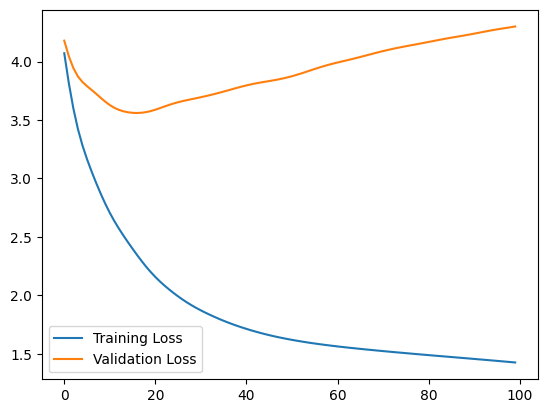

training loss:  1.4404
validation loss:  4.2706


In [14]:
## Plot loss 
import matplotlib.pyplot as plt

plt.figure()
plt.plot(tr_loss, label='Training Loss')
# plt.figure()
plt.plot(vl_loss, label='Validation Loss')
plt.legend()
plt.show()
print('training loss: ', round(torch.mean(torch.tensor(tr_loss[-10:])).item(),4)), 
print('validation loss: ', round((torch.mean(torch.tensor(vl_loss[-10:]))).item(),4))

In [17]:
import torch.nn.functional as F
@torch.no_grad()
def generate(model, max_new_tokens=block_size, batch_size=batch_size, temperature=temperature):
    idx = torch.zeros((batch_size, 1), dtype=torch.long).to(device)
    for _ in range(max_new_tokens):
        # print('idx shape:',idx.shape)
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        idx_cond = idx_cond.to(device)
        logits, _ = model(idx_cond)
        # Pick only the logits from most recent time step. Karpathy also does a divide by temp?
        # This is just Platt scaling which makes the various Softmax curves closes adding more randomness
        # see scratch.ipynb. https://en.wikipedia.org/wiki/Platt_scaling
        logits = logits[:,-1,:]/temperature
        probs = F.softmax(logits, dim=-1)
        # print('prob dist:',probs)
        idx_next = torch.multinomial(probs, num_samples=1)
        # print('idx_next shape:',idx_next.shape)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


In [18]:
X_samp = generate(model, block_size*2, 1, temperature).tolist()

In [19]:
for row in X_samp:
    print(decode(row))


mie nope Wersow theanyor fu theanopl:

Wemire Caro e atius re u ther sol s fu wenoleneanourche.

WeV, Cak. t.
Allve spr tol;hanolve mithemyo th?
!, Pen:he Cizemen k.
Wenow'theo:
WefUedve y amenesto spen faknolved fochen:
Fieakn:
Fir h?
You e myope.
FiGe t, pe the Mare tocheG spemed.
Firato s pe.
All:
Al w h?
Fir3 k, w'th?
FizeFiemit k, Citbar, olven:
mien:
Bemyow't pe bCizen:
Sf r, reou Cak.
Fi'tochirAl:

Yo Cirenonole wemire t pe towMan:


SpearspeZirshe pen:

Yo k.
Red reow'to facize Mame.
Yopr re re en:

